## Text mining and search exam notebook: LDA
Authors: Gaetano Chiriaco, Riccardo Porcedda, Gianmarco Russo

#Imports and drive mount

In [ ]:
!pip install --upgrade gensim
!pip install pyLDAvis
!pip install --upgrade numpy

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import numpy as np

import gensim
import nltk

from nltk.corpus import stopwords

import gensim.corpora as corpora

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer

from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

#import pyLDAvis.gensim
import pickle 
import pyLDAvis
import os
import pyLDAvis.gensim_models as gensimvis

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preprocessing

In [ ]:
df = pd.read_csv("drive/MyDrive/TM&S/data/main_ridotto.csv")

In [ ]:
df.head(5)

,title,sentences
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is..."
1,Bayesian Query Construction for Neural Network...,In this paper we consider the situation wher...
2,"Neural Network Ensembles, Cross Validation, an...",It is well known that a combination of many ...
3,Pulsestream Synapses with Non-Volatile Analogu...,Fusion of the nuclei of hydrogen provides th...
4,Learning to Play the Game of Chess,"Throughout the last decades, the game of ches..."


In [ ]:
df["sentences"][3][0:1000]

"  Fusion of the nuclei of hydrogen provides the energy source which powers the sun. It also offers the possibility of a practically limitless terrestrial source of energy. However, the harnessing of this power has proved to be a highly challenging problem. One of the most promising approaches is based on magnetic confinement of a high temperature (10 7 - 108 Kelvin) plasma in a device called a tokamak (from the Russian for 'toroidal magnetic chamber') as illustrated schematically in Figure 1. At these temperatures the highly ionized plasma is an excellent electrical conductor, and can be confined and shaped by strong magnetic fields. Early tokamaks had plasmas with circular cross-sections, for which feedback control of the plasma position and shape is relatively straightforward. However, recent tokamaks, such as the COMPASS experiment at Culham Laboratory, as well as most next-generation tokamaks, are designed to produce plasmas whose cross-sections are strongly noncircular. Figure 2 

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


def remove_punctuation(text):
    # String punctuation: !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree

def character_repetition(text):
    # Pattern matching for all case alphabets
    # \1   It refers to the first capturing group.
    # {1,} It means we are matching for repetition that occurs more than one time.
    # r’\1\1' → It limits all the repetition to two characters.
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    return Formatted_text

def remove_spaces(text):
    return text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('  ', ' ').replace('\n\n',' ')


def remove_stopwords(tokenized_text):
  stop_words = stopwords.words('english')
  tokenized_text_without_stopwords = []
  for token in tokenized_text:
    if token.lower() not in stop_words and len(token)>2 and token.lower()!="fig":
      tokenized_text_without_stopwords.append(token)
  return tokenized_text_without_stopwords


def lemmatization(tokenized_text):
  wnl = WordNetLemmatizer()
  n_words = len(tokenized_text)
  for idx in range(n_words):
    tokenized_text[idx] = wnl.lemmatize(tokenized_text[idx])
  return tokenized_text


def stemming(tokenized_text):
    stemmer = SnowballStemmer("english")
    n_words = len(tokenized_text)
    for idx in range(n_words):
      tokenized_text[idx] = stemmer.stem(tokenized_text[idx])
    return tokenized_text
    

def preprocess(text,stopword = True, lemma = True,stem=False):
  tokenized_text =  WordPunctTokenizer().tokenize(text)
  if stopword:
    tokenized_text = remove_stopwords(tokenized_text)
  
  if lemma:
    tokenized_text = lemmatization(tokenized_text)
  
  if stem:
    tokenized_text = stemming(tokenized_text)

  return tokenized_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
main_text = df["sentences"]

In [ ]:
# Puctuation removal
main_text = main_text.apply(lambda x: remove_punctuation(x))
# all lower case
main_text = main_text.apply(lambda x: x.lower())
# cipher removal
main_text = main_text.apply(lambda x: re.sub(r'\d+', '', x))
# repeatead character removal
main_text = main_text.apply(lambda x: character_repetition(x))
# excess space removal
main_text = main_text.apply(lambda x: remove_spaces(x))
# lemmatization and stop words removal
main_text = main_text.apply(lambda x: preprocess(x))

In [ ]:
# bigrams calculation
phrase_model = Phrases(main_text, min_count=15, threshold=0.15,scoring="npmi", connector_words=ENGLISH_CONNECTOR_WORDS)
phrase_model.save("drive/MyDrive/TM&S/models/bigrams_model.pkl")

In [ ]:
# substitution of word coupls with bigrams
main_text_bi = phrase_model[main_text]

In [ ]:
# trigrams calculation
phrase_model_tri = Phrases(main_text_bi, min_count=25, threshold=0.30,scoring="npmi", connector_words=ENGLISH_CONNECTOR_WORDS)
phrase_model.save("drive/MyDrive/TM&S/models/trigrams_model.pkl")

In [ ]:
# substitution of word triples with trigrams 
main_text_tri = phrase_model[main_text_bi]

In [ ]:
main_text_tri[0][25:45]

['decrease',
 'estimation_error',
 'increase_number',
 'sample',
 'better',
 'learning',
 'machine',
 'however',
 'expression',
 'performance',
 'incomplete',
 'since',
 'lack',
 'consideration',
 'candidate',
 'assumed',
 'preliminarily',
 'find_good',
 'learning',
 'machine']

In [ ]:
len_docs = [len(x) for x in main_text_tri]
print("Numero di parole per documento\nLunghezza media: {}\nLunghezza massima: {}\nLunghezza minima: {}".format(int(np.mean(len_docs)),np.max(len_docs),np.min(len_docs)))

Numero di parole per documento
Lunghezza media: 1556
Lunghezza massima: 8050
Lunghezza minima: 512


#LDA

In [ ]:
# dictionary creation
id2word = corpora.Dictionary(main_text_tri)

# FILTERING
# Filter out tokens that appear in less than no_below documents (absolute number) or
# more than no_above documents (fraction of total corpus size, not absolute number).
# after (1) and (2), keep only the first keep_n most frequent tokens (or keep all if None).

id2word.filter_extremes(no_below=25, no_above=0.33)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in main_text_tri]

# View
print(corpus[:1][0][:30])

[(0, 1), (1, 2), (2, 1), (3, 5), (4, 1), (5, 3), (6, 2), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 7), (22, 1), (23, 3), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 11)]


In [ ]:
#Save Dictionary
id2word.save("drive/MyDrive/TM&S/models/main_bow.pkl")

In [ ]:
len_filt_docs = [len(x) for x in corpus]
print("Lunghezza media: {}\nLunghezza massima: {}\nLunghezza minima: {}".format(int(np.mean(len_filt_docs)),np.max(len_filt_docs),np.min(len_filt_docs)))

Lunghezza media: 492
Lunghezza massima: 1016
Lunghezza minima: 160


In [ ]:
print(id2word)

Dictionary<22139 unique tokens: ['accelerate', 'acceptable', 'accomplishes', 'accordingly', 'achieved']...>


In [ ]:
# Search for optimal number of topics
ntopics = list(range(5,13))

metrics = pd.DataFrame({'topics':ntopics,'Perplexity':[0.0]*len(ntopics) ,'UMASS':[0.0]*len(ntopics),'UCI':[0.0]*len(ntopics),'NPMI':[0.0]*len(ntopics)})


for t in range(len(ntopics)):
  lda_model = gensim.models.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=ntopics[t],
                                        chunksize=10000,
                                        random_state=100,
                                        passes=15,
                                        iterations=500,
                                        alpha='auto',
                                        eta="auto",
                                        eval_every=None)
  print("N.topic:",ntopics[t], "DONE")
      

  metrics["Perplexity"][t] = lda_model.log_perplexity(corpus)
  metrics["UMASS"][t] = gensim.models.CoherenceModel(model=lda_model, texts=main_text_tri, dictionary=id2word, coherence="u_mass").get_coherence()
  metrics["UCI"][t] = gensim.models.CoherenceModel(model=lda_model, texts=main_text_tri, dictionary=id2word, coherence="c_uci").get_coherence()
  metrics["NPMI"][t] = gensim.models.CoherenceModel(model=lda_model, texts=main_text_tri, dictionary=id2word, coherence="c_npmi").get_coherence()
      

N.topic: 5 DONE


<ipython-input-91-4cb7c63fb855>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["Perplexity"][t] = lda_model.log_perplexity(corpus)
<ipython-input-91-4cb7c63fb855>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metrics["UMASS"][t] = gensim.models.CoherenceModel(model=lda_model, texts=main_text_tri, dictionary=id2word, coherence="u_mass").get_coherence()
<ipython-input-91-4cb7c63fb855>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

N.topic: 6 DONE
N.topic: 7 DONE
N.topic: 8 DONE
N.topic: 9 DONE
N.topic: 10 DONE
N.topic: 11 DONE
N.topic: 12 DONE


In [ ]:
metrics.to_csv("metric_lda.csv")

In [ ]:
metrics = pd.read_csv("drive/MyDrive/TM&S/data/metric_lda.csv",index_col=0)

In [ ]:
#metrics

,topics,Perplexity,UMASS,UCI,NPMI
0,5,-8.771307,-1.415254,0.143113,0.021488
1,6,-8.751517,-1.391393,0.160286,0.023254
2,7,-8.732244,-1.407389,0.207654,0.027186
3,8,-8.707597,-1.421079,0.218427,0.029656
4,9,-8.684531,-1.469997,0.251677,0.034436
5,10,-8.675535,-1.472260,0.423390,0.046432
6,11,-8.670531,-1.541613,0.358176,0.041668
7,12,-8.651402,-1.537391,0.344609,0.042523


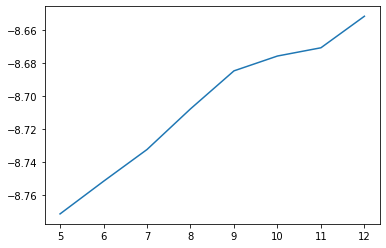

In [ ]:
# Perplexity
plt.plot(metrics["topics"],metrics["Perplexity"])
plt.show()

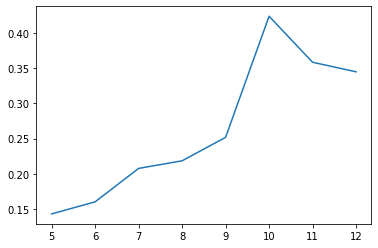

In [ ]:
# UCI
plt.plot(metrics["topics"],metrics["UCI"])
plt.show()

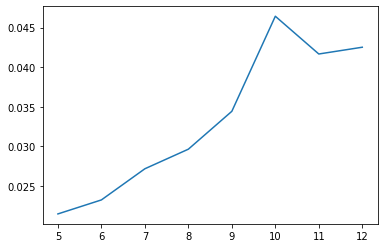

In [ ]:
# NPMI
plt.plot(metrics["topics"],metrics["NPMI"])
plt.show()

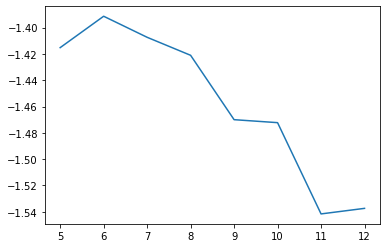

In [ ]:
# C_umass
plt.plot(metrics["topics"],metrics["UMASS"])
plt.show()

In [ ]:
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaModel(corpus=corpus,
                                    id2word=id2word,
                                    num_topics=num_topics,
                                    random_state=100,
                                    chunksize=10000,
                                    passes=15,
                                    iterations=500,
                                    alpha='auto',
                                    eta="auto",
                                    eval_every=None)


In [ ]:
print("Perplexity:",lda_model.log_perplexity(corpus))
print("CM (u_mass):",gensim.models.CoherenceModel(model=lda_model, texts=main_text_tri, dictionary=id2word, coherence="u_mass").get_coherence())
print("CM (uci):",gensim.models.CoherenceModel(model=lda_model, texts=main_text_tri, dictionary=id2word, coherence="c_uci").get_coherence())
print("CM (u_npmi):",gensim.models.CoherenceModel(model=lda_model, texts=main_text_tri, dictionary=id2word, coherence="c_npmi").get_coherence())

Perplexity: -8.675534979752856
CM (u_mass): -1.472260061241538
CM (uci): 0.4233898700594573
CM (u_npmi): 0.046432227780313404


#Results visualization

In [ ]:
from wordcloud import WordCloud

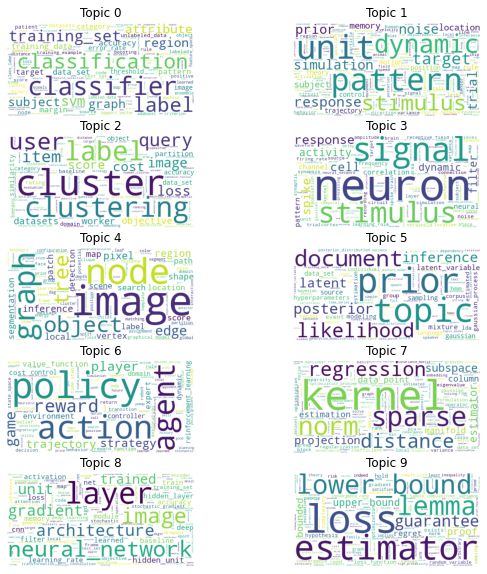

In [ ]:
fig, ax = plt.subplots(5,2, figsize=(9.4,10))
t = 0
for i in range(5):
  for j in range(2):
    ax[i,j].imshow(WordCloud(background_color="white",max_words=500).fit_words(dict(lda_model.show_topic(t, 500))))
    ax[i,j].set_title("Topic {}".format(t))
    ax[i,j].axis("off")
    t+=1

plt.savefig("lda_wc.pdf",dpi=300)
plt.show(fig)


In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word,sort_topics=True)


/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.121197 -0.116980       1        1  16.116620
7     -0.081871 -0.023785       2        1  13.260961
4      0.001935  0.080688       3        1  10.881297
5      0.008270  0.032047       4        1  10.880686
8      0.026362  0.066201       5        1   9.857514
1      0.120670 -0.040775       6        1   9.454131
6      0.012125 -0.119730       7        1   8.440628
2     -0.095074  0.054271       8        1   7.232086
3      0.169923 -0.018759       9        1   7.068380
0     -0.041142  0.086822      10        1   6.807695, topic_info=            Term          Freq         Total Category  logprob  loglift
1421      neuron   8307.000000   8307.000000  Default  30.0000  30.0000
3612      policy   8162.000000   8162.000000  Default  29.0000  29.0000
220        image  20157.000000  20157.000000  Default  28.0000  28.0000
5809  classifier   8134.000000   8134.000000  Default  27.0000  27.0000
968        label  11134.000000  11134.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
2157       score    814.078001   5440.204961  Topic10  -6.1398   0.7876
1190        code    737.467086   3107.724635  Topic10  -6.2386   1.2487
1034    positive    760.212681   4223.315630  Topic10  -6.2083   0.9723
410         rule    781.413763   5766.759735  Topic10  -6.1808   0.6884
306         node    819.105433  12033.783277  Topic10  -6.1337  -0.0001

[843 rows x 6 columns], token_table=       Topic      Freq               Term
term                                     
16180      1  0.965391  absolute_constant
16180      2  0.029034  absolute_constant
4921       1  0.982430      absolute_loss
4921       7  0.010679      absolute_loss
825        1  0.103788           accuracy
...      ...       ...                ...
15290      8  0.828450             worker
15290      9  0.000676             worker
15290     10  0.001351             worker
20831      5  0.980318      yoshua_bengio
20831      8  0.017824      yoshua_bengio

[4743 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 5, 6, 9, 2, 7, 3, 4, 1])

In [ ]:
topic_names = {"0":"Classification",
               "1":"Applications",
               "2":"Clustering",
               "3":"Neuroscience",
               "4":"Image/Graph",
               "5":"NLP",
               "6":"Reinforcement learning",
               "7":"Dimensionality reduction",
               "8":"Neural Networks",
               "9":"Optimization"}

In [ ]:
lda_model.save("/content/drive/MyDrive/TM&S/models/lda_10trigrams")

In [ ]:
lda_model.get_document_topics(corpus,minimum_probability=0)[0]

[(0, 0.044772644),
 (1, 0.48252985),
 (2, 4.2318195e-05),
 (3, 3.824271e-05),
 (4, 0.20481817),
 (5, 0.051235065),
 (6, 0.14794724),
 (7, 6.443668e-05),
 (8, 4.7274683e-05),
 (9, 0.06850474)]

In [ ]:
def assign_topic(model,docs):
  docs_tuples = model.get_document_topics(docs,minimum_probability=0)
  topic_docs = [0]*len(docs_tuples)
  max_prob_docs = [0]*len(docs_tuples)
  for n in range(len(docs_tuples)):
    doc_tuples = docs_tuples[n]
    doc_probs = [0]*model.num_topics
    for i in range(model.num_topics):
      doc_probs[i] = doc_tuples[i][1]
    
    topic = np.argmax(doc_probs)
    prob = np.max(doc_probs)
    topic_docs[n] = topic
    max_prob_docs[n] = prob
  
  return topic_docs, max_prob_docs

In [ ]:
def assign_multitopic(model,docs,threshold = 0.25):
  topic_prob = model.get_document_topics(docs,minimum_probability=0)
  topic_docs = [0]*len(topic_prob)
  for n in range(len(topic_prob)):
    doc = topic_prob[n]
    probs = [0]*model.num_topics
    for i in range(model.num_topics):
      probs[i] = doc[i][1]
    
    topic_list = [i for i in range(model.num_topics) if probs[i]>threshold]
    topic_docs[n] = topic_list
  
  return topic_docs

In [ ]:
topic_docs,prob_docs = assign_topic(lda_model,corpus)

In [ ]:
topic_docs[0:10]

[1, 1, 0, 1, 6, 2, 8, 1, 1, 3]

In [ ]:
multitopics_docs = assign_multitopic(lda_model,corpus)

In [ ]:
multitopics_docs[0:10]

[[1], [1, 9], [0], [1], [6], [2, 7], [8], [1, 8], [1], [3]]

In [ ]:
df["Topic"] = topic_docs

In [ ]:
df["pTopic"] = prob_docs

In [ ]:
df["MultiTopic"] = multitopics_docs

In [ ]:
df

,title,sentences,Topic,pTopic,MultiTopic
0,Self-Organization of Associative Database and ...,"Let a mapping f : X -+ Y be given. Here, X is...",1,0.482530,[1]
1,Bayesian Query Construction for Neural Network...,In this paper we consider the situation wher...,1,0.293866,"[1, 9]"
2,"Neural Network Ensembles, Cross Validation, an...",It is well known that a combination of many ...,0,0.763274,[0]
3,Pulsestream Synapses with Non-Volatile Analogu...,Fusion of the nuclei of hydrogen provides th...,1,0.917823,[1]
4,Learning to Play the Game of Chess,"Throughout the last decades, the game of ches...",6,0.833208,[6]
...,...,...,...,...,...
6189,Learning with Product Units,For over thirty years measuring cancer outco...,0,0.378768,"[0, 1, 8]"
6190,Visual Speech Recognition with Stochastic Netw...,Visual articulation is an important source of...,8,0.273915,"[1, 8]"
6191,"Bias, Variance and the Combination of Least Sq...",Many of the problems related to supervised l...,9,0.642093,"[7, 9]"
6192,Learning direction in global motion: two class...,Global motion perception is critical to many...,1,0.828143,[1]


In [ ]:
for i in df.Topic.unique():
  print(topic_names[str(i)])

Dimensionality reduction
Optimization
Reinforcement learning
Image/Graph
Neuroscience
NLP
Applications
Clustering
Classification
Deep Learning


In [ ]:
for t in df.Topic.unique():
  print("Titoli dei documenti del Topic {} '{}'".format(t,topic_names[str(t)]))
  df_t = df[df["Topic"]==t]
  top_df = df_t.sort_values(by="pTopic",ascending=False).iloc[0:5]
  bot_df = df_t.sort_values(by="pTopic",ascending=True).iloc[0:5]
  print("Top 5:")
  for i in range(top_df.shape[0]):
    print(top_df.title.iloc[i]," (p:",round(top_df.pTopic.iloc[i],3),")")
  print("\n")
  print("Bottom 5:")
  for i in range(bot_df.shape[0]):
    print(bot_df.title.iloc[i],"( p:",round(bot_df.pTopic.iloc[i],3),")")
  
  print("\n\n")

Titoli dei documenti del Topic 1 'Applications'
Top 5:
Load and Attentional Bayes  (p: 1.0 )
Causal inference in sensorimotor integration  (p: 1.0 )
Multiple timescales and uncertainty in motor adaptation  (p: 1.0 )
Neural Network Computation by In Vitro Transcriptional Circuits  (p: 1.0 )
Unifying the Sensory and Motor Components of Sensorimotor Adaptation  (p: 1.0 )


Bottom 5:
Learning Motion Style Synthesis from Perceptual Observations ( p: 0.242 )
A Holistic Approach to Compositional Semantics: a connectionist model and robot experiments ( p: 0.282 )
Probability Estimation from a Database Using a Gibbs Energy Model ( p: 0.286 )
A Note on Learning Vector Quantization ( p: 0.287 )
Energy Disaggregation via Discriminative Sparse Coding ( p: 0.293 )



Titoli dei documenti del Topic 0 'Classification'
Top 5:
FloatBoost Learning for Classification  (p: 0.984 )
Combinations of Weak Classifiers  (p: 0.979 )
Fast and Robust Classification using Asymmetric AdaBoost and a Detector Cascade  

In [ ]:
df.groupby("Topic").count().iloc[:,0]

Topic
0     352
1     640
2     357
3     484
4     635
5     695
6     516
7     911
8     542
9    1062
Name: title, dtype: int64